In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import torch
import matplotlib.pyplot as plt

from gs_init_compare.monocular_depth_init.utils.image_filtering import spatial_gradient_first_order

with open('../aligned_depth.pkl', 'rb') as f:
# with open('aligned_depth.pkl', 'rb') as f:
    depth = torch.from_numpy(pickle.load(f))

with open('../rgb.pkl', 'rb') as f:
# with open('rgb.pkl', 'rb') as f:
    rgb = torch.from_numpy(pickle.load(f))


def show_img(img: torch.Tensor, opacity=1, show=True):
    data_max_range = max(abs(img.max()), abs(img.min()))
    if img.shape[0] in (3, 1):
        img = img.permute(1, 2, 0)
    if img.min() < 0:
        plt.imshow(img.squeeze(), cmap='seismic', vmin=-data_max_range, vmax= data_max_range, alpha=opacity)
    else:
        plt.imshow(img.squeeze(), cmap='viridis', alpha=opacity)
    plt.colorbar()
    # plt.set_cmap(plt.colormaps.get('berlin'))
    if show:
        plt.show()

rgb.shape


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


torch.Size([840, 1297, 3])

In [ ]:
import torch
from gs_init_compare.monocular_depth_init.adaptive_subsampling import (
    calculate_downsample_factor_map,
    get_sample_mask,
)

TILE_SIZE = 20
downsample_map = calculate_downsample_factor_map(
    rgb, possible_subsample_factors=(5, 10, 20, 30), tile_size=TILE_SIZE
)
mask = get_sample_mask(downsample_map, rgb.shape[:2])
mask.shape

torch.Size([840, 1297])

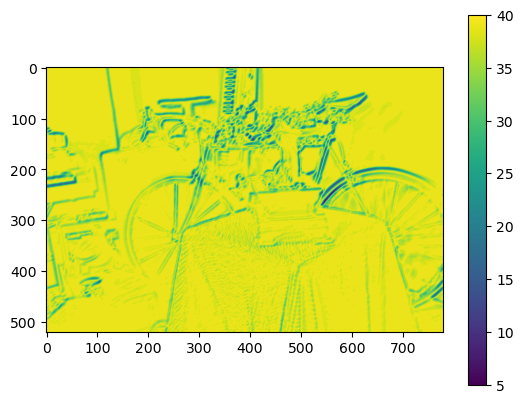

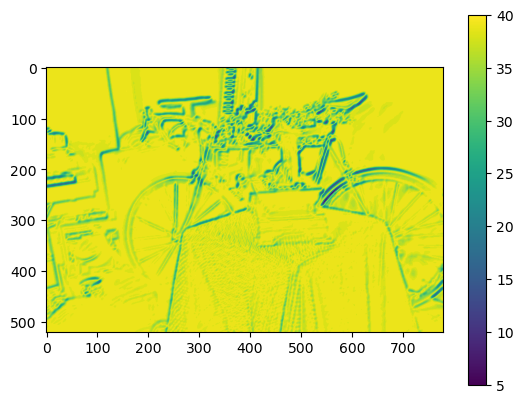

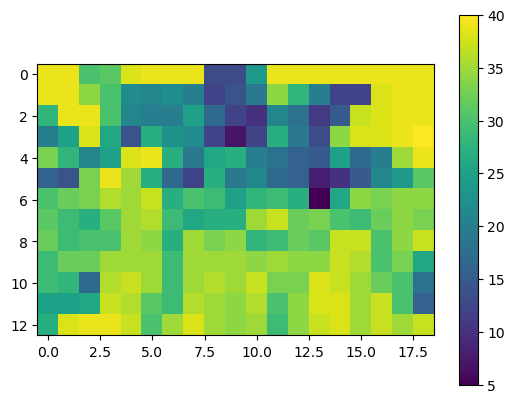

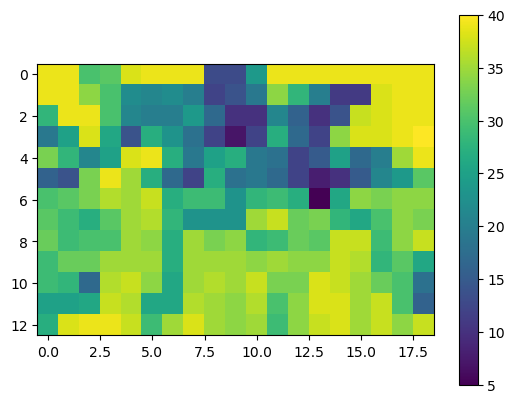

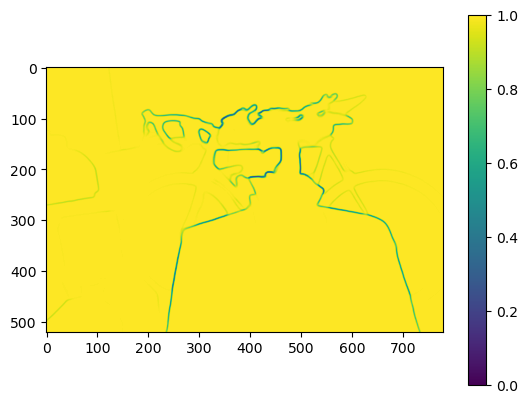

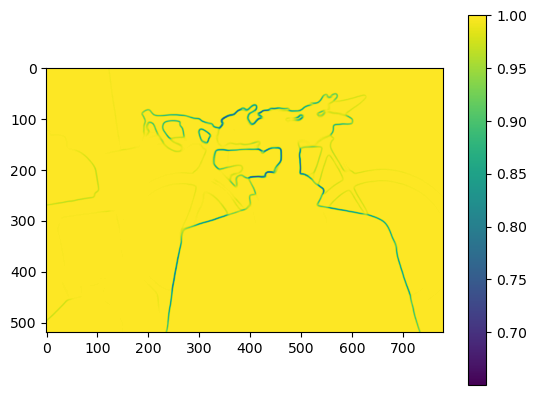

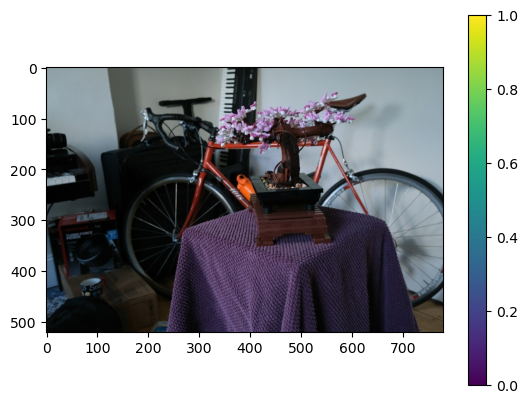

In [ ]:
from gs_init_compare.monocular_depth_init.adaptive_subsampling import map_to_range


GRAD_APPROX_SIGMA = 2
UNIFORM_SUBSAMPLING_AREA_SIZE = 40
SUBSAMPLE_SIZE_RANGE = (5, UNIFORM_SUBSAMPLING_AREA_SIZE)

def gradient(img):
    return spatial_gradient_first_order(img, sigma=GRAD_APPROX_SIGMA).sum(1).sum(1)

def cos_normal2view_dir(depth: torch.Tensor):
    grad = spatial_gradient_first_order(
        depth[None, None], sigma=GRAD_APPROX_SIGMA*2
    ).squeeze()
    grad = grad/grad.max()
    dzdx, dzdy = grad[0], grad[1]
    # show_img(dzdx)
    # show_img(dzdy)

    one = torch.ones_like(depth)
    return one / torch.sqrt(dzdx**2 + dzdy**2 + one)

h, w, _ = rgb.shape
def avg_pool_grad(grad):
    return torch.nn.functional.adaptive_avg_pool2d(
        grad, [h // UNIFORM_SUBSAMPLING_AREA_SIZE, w // UNIFORM_SUBSAMPLING_AREA_SIZE]
    )

def max_pool_grad(grad):
    return torch.nn.functional.adaptive_max_pool2d(
        grad, [h // UNIFORM_SUBSAMPLING_AREA_SIZE, w // UNIFORM_SUBSAMPLING_AREA_SIZE]
    )

color_grad = gradient(rgb.permute(2, 0, 1)[None])
color_grad = map_to_range(color_grad.abs())

cos_normal_2_view = cos_normal2view_dir(depth)
test = 2. / (1. + torch.exp(5. * cos_normal_2_view))

test2 = cos_normal_2_view.clone()
test2[test2 < 0.5] = 0.5
test2 = map_to_range(test2)


# TODO: this actually removes details from regions which are at an angle, but since the real big angles appear at object boundaries, this should be better, 
# since that's not real surfaces which are at an angle, but borders between projected objects, which we actually don't want to increase sampling factor for
# TODO: check if what I wrote above makes some sense
def calc_df(pool_fn=lambda x:x, enable_edge_compensation=True):
    if enable_edge_compensation:
        df = map_to_range(color_grad * map_to_range(test2))
    else:
        df = map_to_range(color_grad)

    # show_img(map_to_range(cos_normal_2_view))
    df = 1 - map_to_range(pool_fn(df))
    df = df * (SUBSAMPLE_SIZE_RANGE[1] - SUBSAMPLE_SIZE_RANGE[0]) + SUBSAMPLE_SIZE_RANGE[0]
    return df.to(int)

show_img(calc_df())
show_img(calc_df(enable_edge_compensation=False))
show_img(calc_df(max_pool_grad, enable_edge_compensation=True))
show_img(calc_df(max_pool_grad, enable_edge_compensation=False))
show_img(test2)
show_img(cos_normal_2_view)
# show_img(test)
show_img(rgb, opacity=1, show=True)


# v1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4675558].


torch.Size([1, 520, 779])


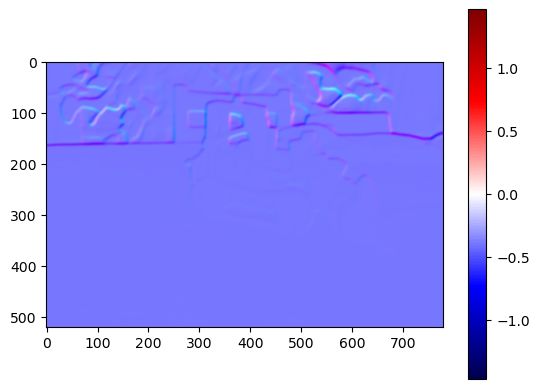

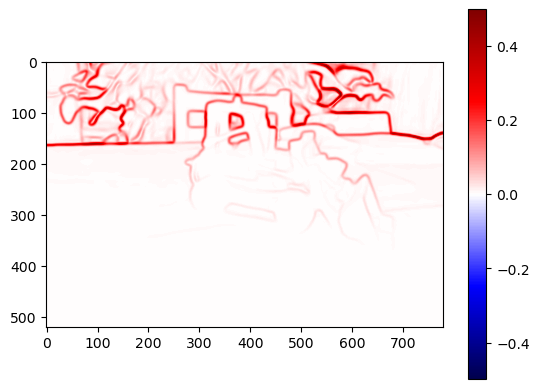

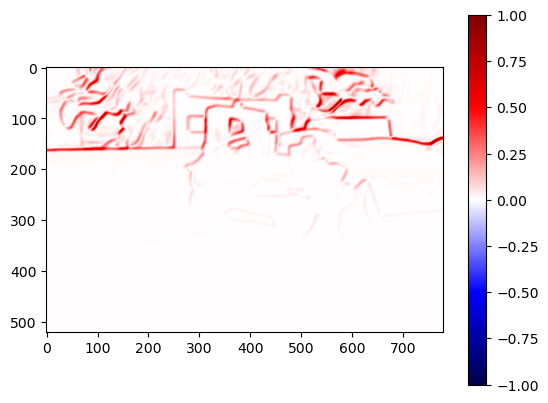

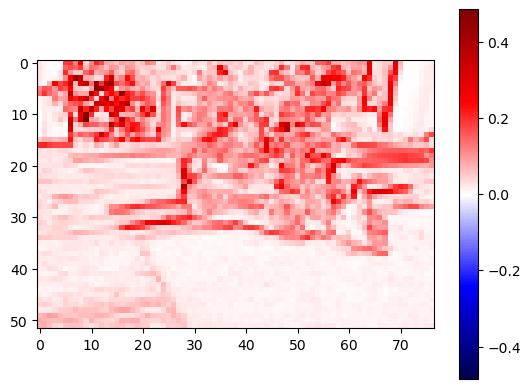

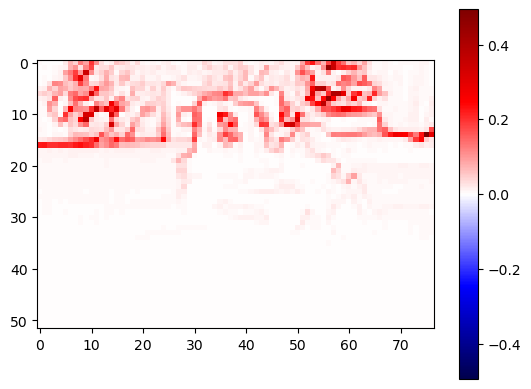

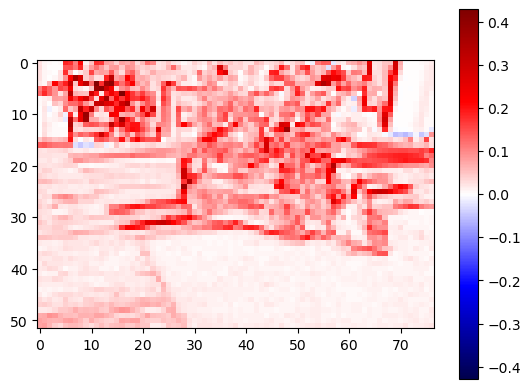

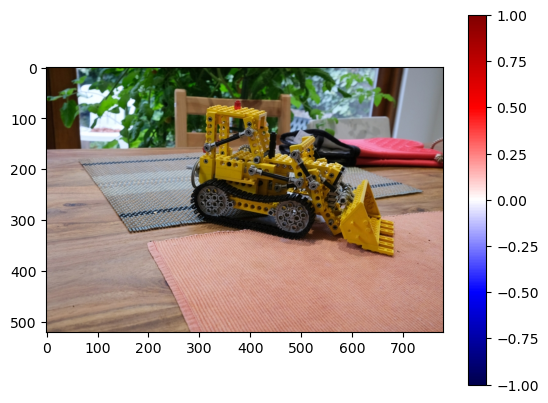

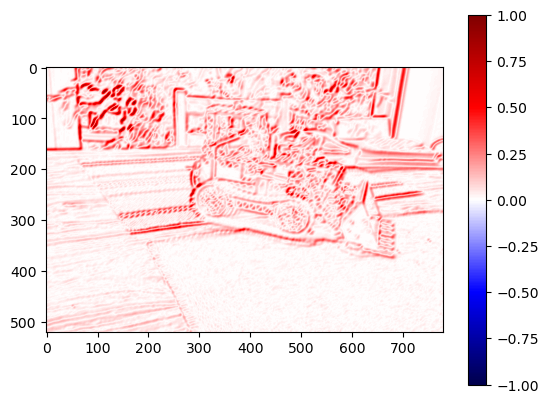

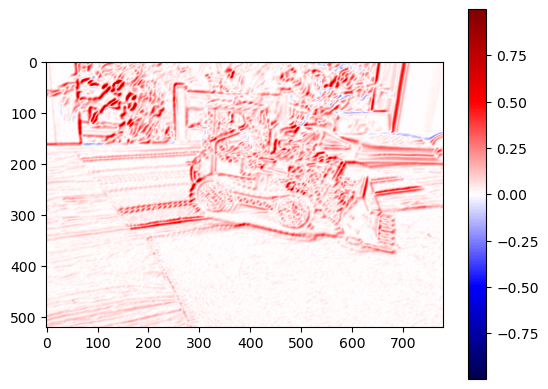

torch.Size([1, 52, 77])

In [ ]:
def gradient(img):
    return spatial_gradient_first_order(img, sigma=2).sum(1).sum(1)

color_grad = gradient(rgb.permute(2, 0, 1)[None])
depth_grad = gradient(depth[None, None])
print(color_grad.shape)

color_grad = color_grad.abs()
depth_grad = depth_grad.abs()

color_grad = color_grad/color_grad.max()
depth_grad = depth_grad/depth_grad.max()

_, h, w = color_grad.shape

UNIFORM_SUBSAMPLING_AREA_SIZE = 10

def avg_pool_grad(grad):
    return torch.nn.functional.adaptive_avg_pool2d(
        grad, [h // UNIFORM_SUBSAMPLING_AREA_SIZE, w // UNIFORM_SUBSAMPLING_AREA_SIZE]
    )
color_grad_avg = avg_pool_grad(color_grad)
depth_grad_avg = avg_pool_grad(depth_grad)

def cos_normal2view_dir(depth):
    grad = spatial_gradient_first_order(depth[None,None], sigma=2).squeeze()
    depth_grad_x = grad[0]
    depth_grad_y = grad[1]
    
    normal_x = depth_grad_x / torch.sqrt(depth_grad_x**2 + depth_grad_y**2 + 1)
    normal_y = depth_grad_y / torch.sqrt(depth_grad_x**2 + depth_grad_y**2 + 1)
    normal_z = 1 / torch.sqrt(depth_grad_x**2 + depth_grad_y**2 + 1)
    
    normals = torch.dstack([normal_x, normal_y, normal_z])
    normals = normals / torch.linalg.vector_norm(normals, dim=2)[:,:,None]
    return normals
    

def lerp(a, b, t):
    return a * (1 - t) + b *t

neg_depth_ratio = 0.3
combined = color_grad - depth_grad * neg_depth_ratio
combined_grad_avg = color_grad_avg - depth_grad_avg * neg_depth_ratio
# combined = lerp(color_grad, depth_grad, 0.7)
# combined_grad_avg = lerp(color_grad_avg, depth_grad_avg, 0.7)
normals = cos_normal2view_dir(depth)
smth = torch.linalg.vector_norm(normals - torch.tensor([0, 0, 1], dtype=normals.dtype)[None, None, :], dim=2)
show_img(normals + normals.min().abs())
show_img(smth)
show_img(depth_grad)
show_img(color_grad_avg)
show_img(depth_grad_avg)
show_img(combined_grad_avg)
show_img(rgb, opacity=1, show=True)
show_img(color_grad)
show_img(combined)
color_grad_avg.shape

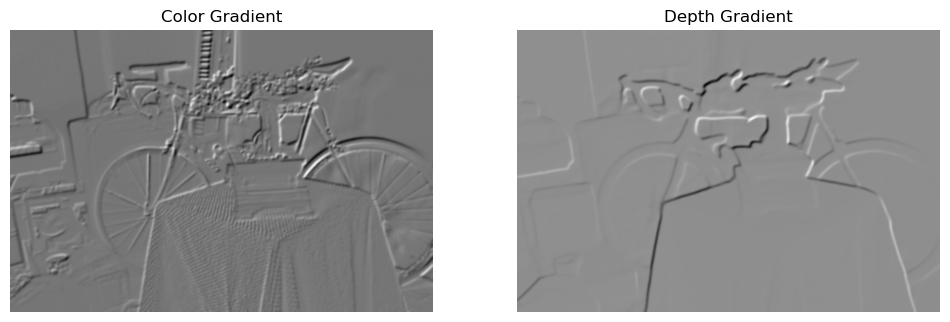